In [63]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



### Data Preprocessing

In [2]:
train_directory = "Covid19-dataset/train"
test_directory = "Covid19-dataset/test"

In [16]:
covid_img = plt.imread(os.path.join(train_directory, 'Covid/101.png'))
normal_img = plt.imread(os.path.join(train_directory, 'Normal/1.png'))
pneumonia_img = plt.imread(os.path.join(train_directory, 'Pneumonia/111.png'))

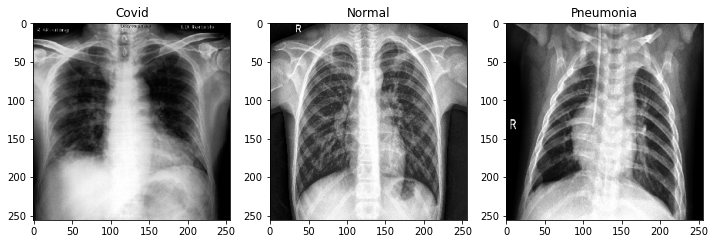

In [27]:
fig= plt.figure(figsize=(12, 8))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)

plt.imshow(covid_img)
plt.title('Covid')

fig.add_subplot(rows, columns, 2)

plt.imshow(normal_img)
plt.title('Normal')

fig.add_subplot(rows, columns, 3)

plt.imshow(pneumonia_img)
plt.title('Pneumonia');

In [3]:
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [4]:
training_iterator = train_image_generator.flow_from_directory(
    train_directory,
    target_size=(256,256),
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = 32)

Found 251 images belonging to 3 classes.


In [5]:
training_iterator.image_shape

(256, 256, 1)

In [28]:
training_iterator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

In [48]:
testing_iterator = train_image_generator.flow_from_directory(
    test_directory,
    target_size=(256,256),
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = 32,
    shuffle=False)

Found 66 images belonging to 3 classes.


In [49]:
testing_iterator.image_shape

(256, 256, 1)

In [50]:
testing_iterator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

### Model Creation

In [93]:
## Iniatilize Sequential Model
model = Sequential()
## Input layer
model.add(layers.Input(shape = training_iterator.image_shape))

model.add(layers.Conv2D(16, 3, strides =3, padding ='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
## Output layer
model.add(layers.Dense(3,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 86, 86, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 43, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14112)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 42339     
Total params: 47,139
Trainable params: 47,139
Non-trainable params: 0
__________________________________________________

### Train/Test Model

In [52]:
history = model.fit(training_iterator,
                epochs=20,
                batch_size = 32,
                validation_data = testing_iterator)

Epoch 1/20
8/8 [==============================] - 2s 234ms/step - loss: 1.1171 - accuracy: 0.4741 - val_loss: 0.9477 - val_accuracy: 0.5909
Epoch 2/20
8/8 [==============================] - 2s 223ms/step - loss: 0.7687 - accuracy: 0.7649 - val_loss: 0.7415 - val_accuracy: 0.6515
Epoch 3/20
8/8 [==============================] - 2s 210ms/step - loss: 0.5110 - accuracy: 0.8964 - val_loss: 0.5807 - val_accuracy: 0.6818
Epoch 4/20
8/8 [==============================] - 2s 242ms/step - loss: 0.3212 - accuracy: 0.9124 - val_loss: 0.4999 - val_accuracy: 0.7273
Epoch 5/20
8/8 [==============================] - 2s 237ms/step - loss: 0.2251 - accuracy: 0.9203 - val_loss: 0.4463 - val_accuracy: 0.7424
Epoch 6/20
8/8 [==============================] - 2s 213ms/step - loss: 0.1970 - accuracy: 0.9363 - val_loss: 0.4047 - val_accuracy: 0.8182
Epoch 7/20
8/8 [==============================] - 2s 231ms/step - loss: 0.1723 - accuracy: 0.9402 - val_loss: 0.3756 - val_accuracy: 0.8333
Epoch 8/20
8/8 [====

In [54]:
test_steps_per_epoch = np.math.ceil(testing_iterator.samples / testing_iterator.batch_size)

predictions = model.predict(testing_iterator, steps= test_steps_per_epoch)
y_pred = np.argmax(predictions, axis=1)

In [58]:
y_true = testing_iterator.classes
y_true_labels = list(testing_iterator.class_indices.keys())

In [59]:
report = classification_report(y_true, y_pred, target_names=y_true_labels)
print(report)

              precision    recall  f1-score   support

       Covid       0.89      0.96      0.93        26
      Normal       0.86      0.95      0.90        20
   Pneumonia       0.94      0.75      0.83        20

    accuracy                           0.89        66
   macro avg       0.90      0.89      0.89        66
weighted avg       0.90      0.89      0.89        66



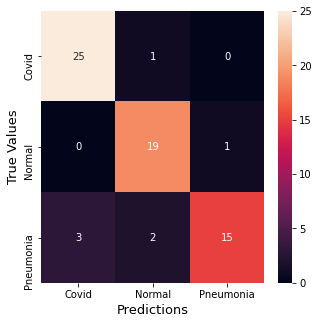

In [88]:
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(5,5))
s = sns.heatmap(cm, annot=True,
            xticklabels=['Covid', 'Normal', 'Pneumonia'], 
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
s.set_xlabel('Predictions', fontsize=13)
s.set_ylabel('True Values', fontsize=13);

Looks like our model did a pretty good job of predicting the test set, shwoing an accuracy of 90% and correctly predicting 25 out of the 26 lungs with covid

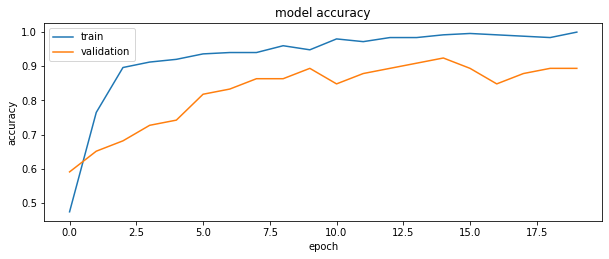

In [98]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

Let's check out if the model can perform even better with more epochs

In [94]:
history2 = model.fit(training_iterator,
                epochs=40,
                batch_size = 32,
                validation_data = testing_iterator)

Epoch 1/40
8/8 [==============================] - 2s 263ms/step - loss: 1.0055 - accuracy: 0.4661 - val_loss: 0.9295 - val_accuracy: 0.6364
Epoch 2/40
8/8 [==============================] - 2s 260ms/step - loss: 0.6833 - accuracy: 0.8606 - val_loss: 0.6702 - val_accuracy: 0.7727
Epoch 3/40
8/8 [==============================] - 2s 234ms/step - loss: 0.3990 - accuracy: 0.8845 - val_loss: 0.4681 - val_accuracy: 0.7727
Epoch 4/40
8/8 [==============================] - 2s 227ms/step - loss: 0.2439 - accuracy: 0.9243 - val_loss: 0.4256 - val_accuracy: 0.8182
Epoch 5/40
8/8 [==============================] - 2s 235ms/step - loss: 0.1991 - accuracy: 0.9124 - val_loss: 0.3729 - val_accuracy: 0.8939
Epoch 6/40
8/8 [==============================] - 2s 244ms/step - loss: 0.1859 - accuracy: 0.9283 - val_loss: 0.4037 - val_accuracy: 0.8485
Epoch 7/40
8/8 [==============================] - 2s 264ms/step - loss: 0.1861 - accuracy: 0.9243 - val_loss: 0.3761 - val_accuracy: 0.8182
Epoch 8/40
8/8 [====

In [90]:
test_steps_per_epoch = np.math.ceil(testing_iterator.samples / testing_iterator.batch_size)

predictions = model.predict(testing_iterator, steps= test_steps_per_epoch)
y_pred = np.argmax(predictions, axis=1)

y_true = testing_iterator.classes
y_true_labels = list(testing_iterator.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=y_true_labels)
print(report)

              precision    recall  f1-score   support

       Covid       0.93      0.96      0.94        26
      Normal       0.86      0.95      0.90        20
   Pneumonia       0.94      0.80      0.86        20

    accuracy                           0.91        66
   macro avg       0.91      0.90      0.90        66
weighted avg       0.91      0.91      0.91        66



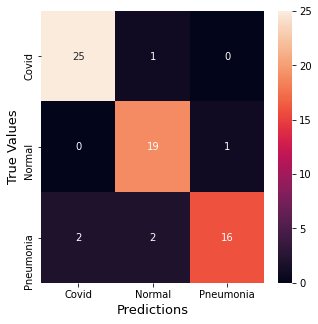

In [91]:
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(5,5))
s = sns.heatmap(cm, annot=True,
            xticklabels=['Covid', 'Normal', 'Pneumonia'], 
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
s.set_xlabel('Predictions', fontsize=13)
s.set_ylabel('True Values', fontsize=13);

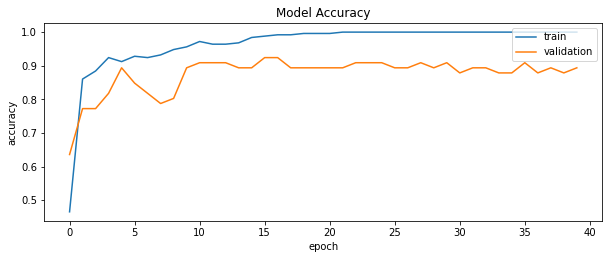

In [97]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history2.history['accuracy'])
ax1.plot(history2.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper right')

Going from 20 to 40 epochs doesn't seem to have made too much of a difference, going from 89% accuracy to 90%, but the model accuracy chart above gives us a good sense of how the model's accuracy levels out after around 15 epochs
